# GBFS Test Output Stuff
###### Note:
Boulder BCycle uses version 1.1, which is kinda old (2.2 is recommeneded by NABSA)<br>
Here's a link to the 1.1 json schema:<br>
https://github.com/MobilityData/gbfs-json-schema/tree/v1.1 <br>

I have no idea if this stuff will work with a different version.

### Questions

Some instants have no stations listed (1644088877 and 1648983815 for example). It's not like they're all "uninstalled" or anything, they just aren't there. The 'stations' key is an empty list. Why is that? Is it some kind of maintenance thing or something?

### Setup

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import json
from datetime import datetime
import csv
from scipy import stats

%matplotlib widget

In [22]:
#Get the streets and buildings that we'll want to see on maps:
buildings = None
with open('buildings_cu.json') as f:
    buildings = json.loads(f.read())

streets = None
with open('streets_near_campus.json') as f: #these will have duplicates. There are multiple entries for roads like Broadway
    streets = json.loads(f.read())

In [23]:
print("CU Buildings: {}".format(len(buildings)))
print("Near Campus Streets: {} (there are probably duplicates)".format(len(streets)))

CU Buildings: 423
Near Campus Streets: 806 (there are probably duplicates)


In [24]:
#Get station information (latitude and longitude, names)
stations = None
with open('station_information.json') as f: #TODO: Use urlopen to get the current one?
    stations = json.loads(f.read())['data']['stations']

print("There are {} Boulder BCycle Stations".format(len(stations)))

#Do some convenience stuff to stations:

#make it a dictionary with ids as keys
temp = stations
stations = {}
for station in temp:
    stations[station['station_id']] = station

#For convenience:
def GetStationID(stationName):
    for stationID in stations:
        if stations[stationID]['name'] == stationName:
            return stationID
    return None

There are 45 Boulder BCycle Stations


In [25]:
#Get station info from the checkouts data
with open('Boulder BCycle Kiosk Checkout Report December 2021-February 2022.csv', newline='') as f:
    reader = csv.reader(f)
    lines = [row for row in reader]
    
    #for each row
    #Ignore the first row with the labels
    for i in range(1, len(lines)):
        stationID = GetStationID(lines[i][0])
        
        #Make sure we actually found the id of the station we're looking for
        if stationID is not None:
            stations[stationID]['found_checkouts_data'] = True
            stations[stationID]['total_docks'] = int(lines[i][1])
        else:
            #if we couldn't find the total number of docks here, we'll try and get it from the GBFS data.
            print("Couldn't find ID for station: {}".format(lines[i][0]))

Couldn't find ID for station: 11th & Pearl
Couldn't find ID for station: 38th & Arapahoe
Couldn't find ID for station: Fisher Drive and Exposition Drive
Couldn't find ID for station: Boulder Junction North
Couldn't find ID for station: 20th & Pearl


In [6]:
#Load the status files the slow way
data = [] #This will be a list of the dictionaries given by GBFS, in chronological order.
dataFolder = 'GBFSTest1_StationStatus_Output'
allFiles = os.listdir(dataFolder)
allFiles.sort() #alphabetical. Their names are their unix timestamps ('last_updated'), so chronological order

for file in allFiles:
    with open('{}/{}'.format(dataFolder, file)) as f:
        data.append(json.loads(f.read()))

print("Found {} files, from {} to {}.".format(len(data), data[0]['last_updated'], data[-1]['last_updated']))

Found 84901 files, from 1644027738 to 1650658594.


In [7]:
#Do some convenience stuff to data:
for instant in data:
    #time:
    instant['time'] = instant['last_updated']
    instant['readable_time'] = datetime.fromtimestamp(instant['time']).ctime() #local time. if you run this in a different timezone, it'll get messed up.
    
    #the only thing that the 'data' key contains is the stations key, so there's no reason to have it
    #This will make it more convenient to work with here even if there are multiple keys in data in the future.
    for key in instant['data']:
        instant[key] = instant['data'][key]
    del instant['data']
    
    #each station's 'is_returning', 'is_renting', and 'is_installed' keys are integers that seem to be booleans.
    #replace them with True and False
    #I think they are actually booleans in newer versions of GBFS, but not this one.
    for station in instant.get('stations', []):
        station['is_returning'] = bool(station['is_returning'])
        station['is_renting'] = bool(station['is_renting'])
        station['is_installed'] = bool(station['is_installed'])
    
    #'stations' is a list, but I want to be able to access each station by its id
    #so this makes 'stations' a dictionary where the keys are the ids, and the values are the list elements
    temp = instant['stations']
    instant['stations'] = {}
    for station in temp:
        instant['stations'][station['station_id']] = station

In [8]:
#Save data so we can load the same set more quickly in the future
with open('GBFSData_{}.json'.format(len(data)), 'w') as f:
    f.write(json.dumps(data))

In [26]:
#load the data the (hopefully) faster way (using the last one we saved from the last time we did it)
#This looks at all the ones that exist in the current folder and loads the largest one.
#Faster because one big file instead of about 80000 tiny ones.

files = os.listdir('.')
files = [path for path in files if path.startswith("GBFSData_")]

print('Previously saved data lists:')
print(files)

n = max([path[9:-5] for path in files])
print('loading GBFSData_{}.json'.format(n))

with open('GBFSData_{}.json'.format(n)) as f:
    data = json.loads(f.read())

print("data has length: {}".format(len(data)))

Previously saved data lists:
['GBFSData_84812.json', 'GBFSData_84901.json']
loading GBFSData_84901.json
data has length: 84901


In [27]:
#For any stations where we couldn't find checkouts data to give us the actual total number of docks, we'll have to infer it.
#For some reason, the sum of a station's num_bikes_available and num_docks_available can vary.
#My initial guess was that it would decrease for maintenance, but sometimes it's actually GREATER than the real total (by 1)
#My assumption here is that the mode of the calculated number of docks would be the real value.

for stationID in stations:
    if stations[stationID].get('found_checkouts_data') != True:
        print("Didn't find checkouts data for station:\n{} - \'{}\'".format(stationID, stations[stationID]['name']))
        stations[stationID]['found_checkouts_data'] = False
        totals = [instant[stationID]['num_bikes_available'] + instant[stationID]['num_docks_available'] for instant in data if instant.get(stationID)]
        print("found {} updates".format(len(totals)))
        stations[stationID]['total_docks'] = stats.mode(totals)[0][0] if len(stats.mode(totals)[0]) != 0 else 0
        print("Mode is {}\n".format(stations[stationID]['total_docks']))
        

Didn't find checkouts data for station:
bcycle_boulder_3876 - '33rd & Walnut'
found 0 updates
Mode is 0



In [28]:
print(data[0]['stations']['bcycle_boulder_1855']) #Folsom and Colorado

{'is_returning': True, 'is_renting': True, 'is_installed': True, 'num_docks_available': 13, 'num_bikes_available': 0, 'last_reported': 1644027738, 'num_bikes_available_types': {'electric': 0, 'smart': 0, 'classic': 0}, 'station_id': 'bcycle_boulder_1855'}


### List of all Stations

In [29]:
for station in stations:
    print('{:40s} {:2d} docks - ({:7f}, {:7f})'.format(stations[station]['name'], stations[station]['total_docks'], stations[station]['lat'], stations[station]['lon']))

Folsom & Colorado                        15 docks - (40.008110, -105.263850)
15th & Pearl                             15 docks - (40.018720, -105.275840)
13th & Spruce                            14 docks - (40.019090, -105.278900)
UCAR Center Green                        13 docks - (40.031540, -105.246110)
Library @ Arapahoe                       11 docks - (40.013770, -105.280870)
26th @ Pearl                             11 docks - (40.021600, -105.259840)
Municipal Building                        9 docks - (40.015080, -105.279590)
UCAR Mitchell Lane                       13 docks - (40.036430, -105.242260)
Broadway & Alpine                        13 docks - (40.025430, -105.281440)
19th @ Boulder Creek                     13 docks - (40.011670, -105.270180)
28th & Canyon                             9 docks - (40.017780, -105.258710)
The Village                              14 docks - (40.014910, -105.260610)
6th & Canyon                             11 docks - (40.015060, -105.287290)

### Map of All Stations

The color indicates whether we found a good total_docks number for that station.

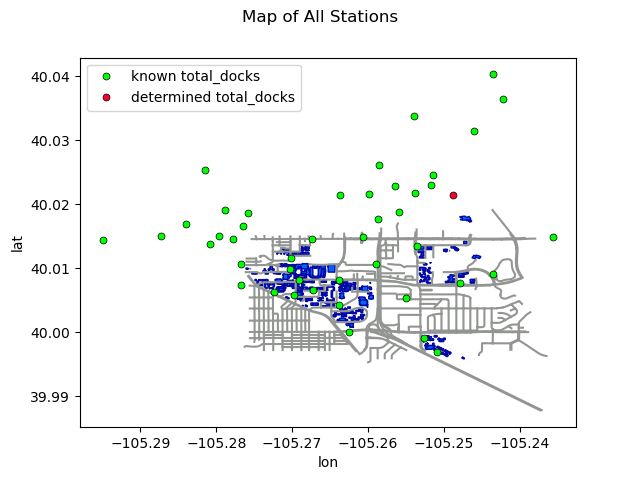

In [30]:
#plot
plt.figure()
plt.suptitle('Map of All Stations')

for building in buildings:
    x = [pair[0] for pair in building['geometry']['coordinates'][0]]
    y = [pair[1] for pair in building['geometry']['coordinates'][0]]

    plt.fill(x, y, facecolor='xkcd:bright blue', edgecolor='xkcd:cobalt blue')

for street in streets:
    x = [pair[0] for pair in street['geometry']['coordinates']]
    y = [pair[1] for pair in street['geometry']['coordinates']]

    plt.plot(x, y, color='xkcd:grey')

lats = [stations[station]['lat'] for station in stations if stations[station].get('found_checkouts_data')]
lons = [stations[station]['lon'] for station in stations if stations[station].get('found_checkouts_data')]
plt.plot(lons, lats, '.', color=(0, 1, 0), label="known total_docks", markersize=10, markeredgewidth=0.5, markeredgecolor='black')

lats = [stations[station]['lat'] for station in stations if not stations[station].get('found_checkouts_data')]
lons = [stations[station]['lon'] for station in stations if not stations[station].get('found_checkouts_data')]
plt.plot(lons, lats, '.', color='xkcd:cherry red', label="determined total_docks", markersize=10, markeredgewidth=0.5, markeredgecolor='black')
    
plt.ylabel('lat')
plt.xlabel('lon')
plt.ticklabel_format(useOffset=False)

plt.legend()

plt.show()

### Histogram of how full a given station is:

TODO: Why do they all have different numbers of docks in different updates? Is it maintenance? What is the true number of docks at each station? Is the checkouts spreadsheet correct? If it is maintenance, and those other docks are legitimitely unavailable at that time, should we use fraction full instead of the number of bikes?

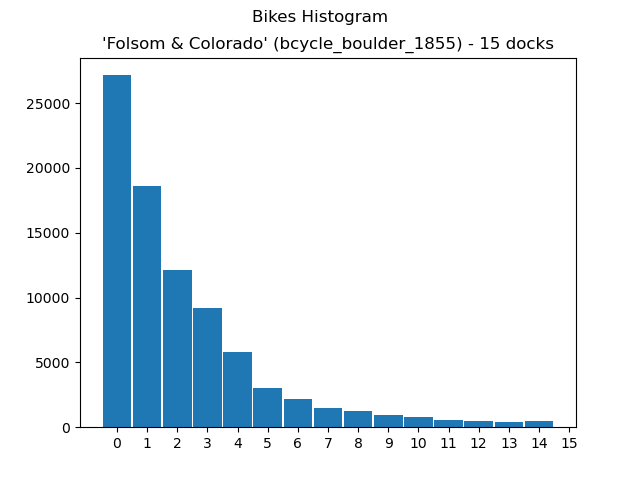

from 84394 updates


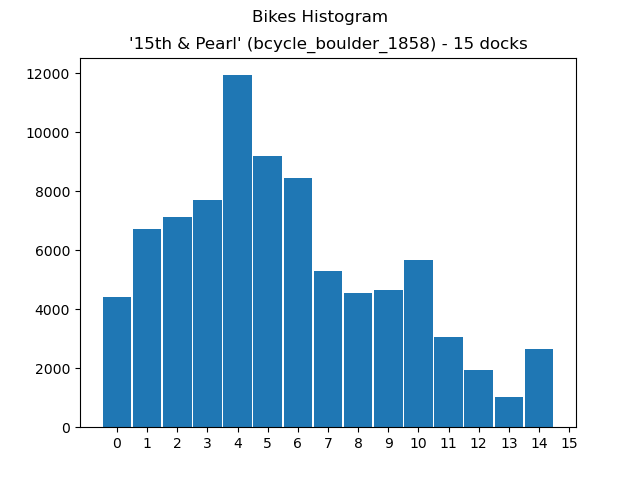

from 84394 updates


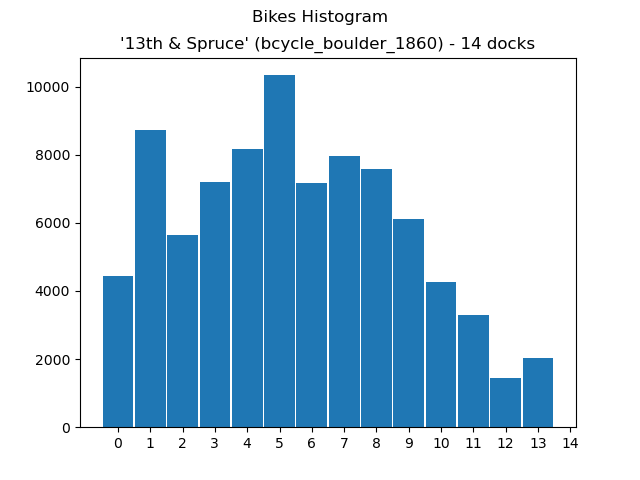

from 84394 updates


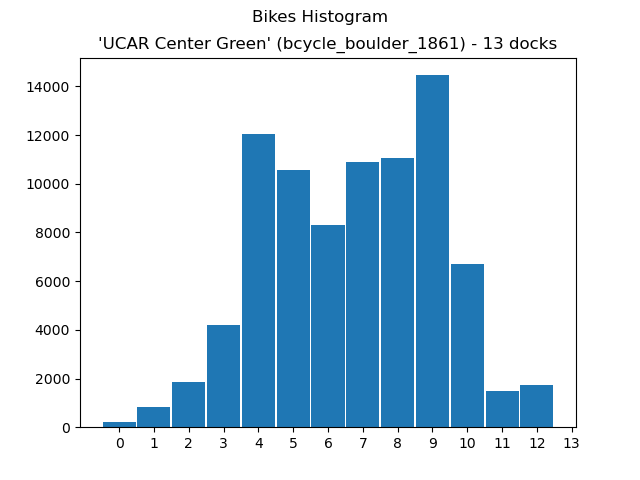

from 84394 updates


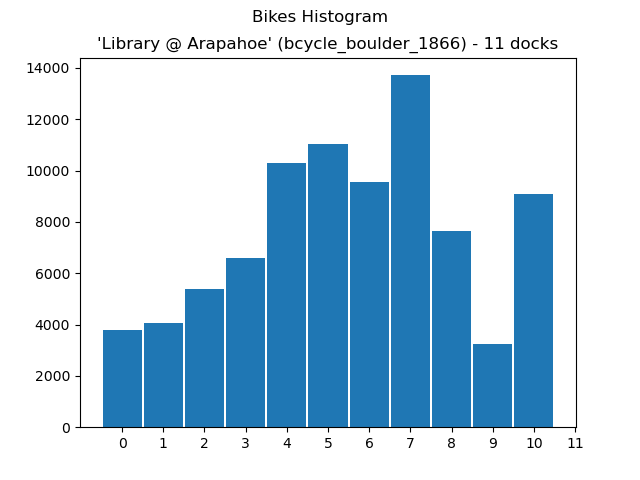

from 84394 updates


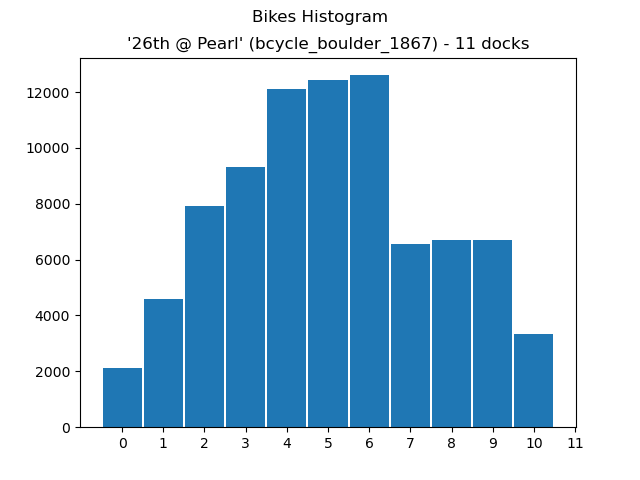

from 84394 updates


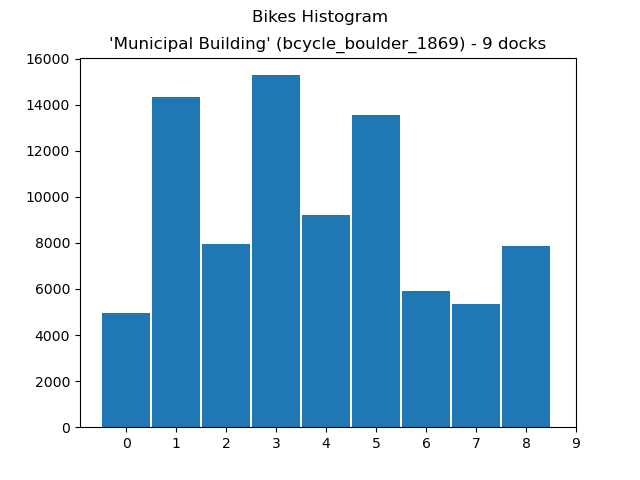

from 84394 updates


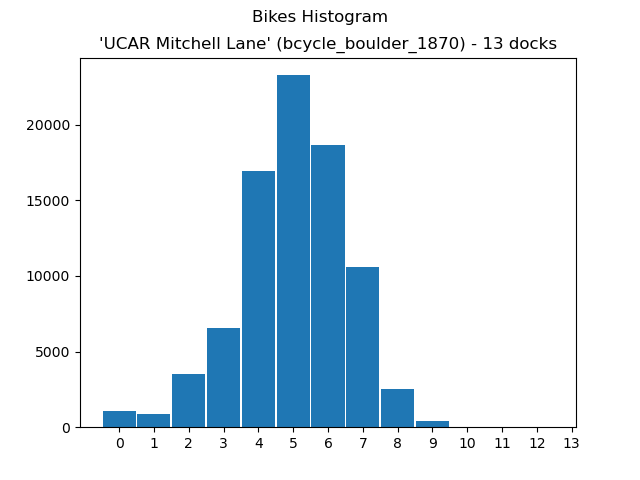

from 84394 updates


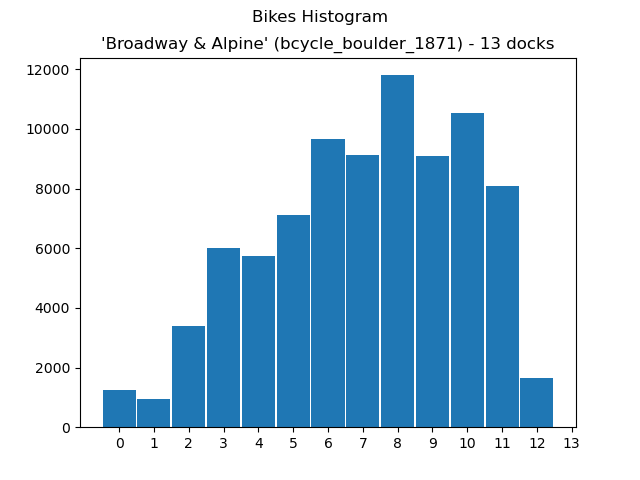

from 84394 updates


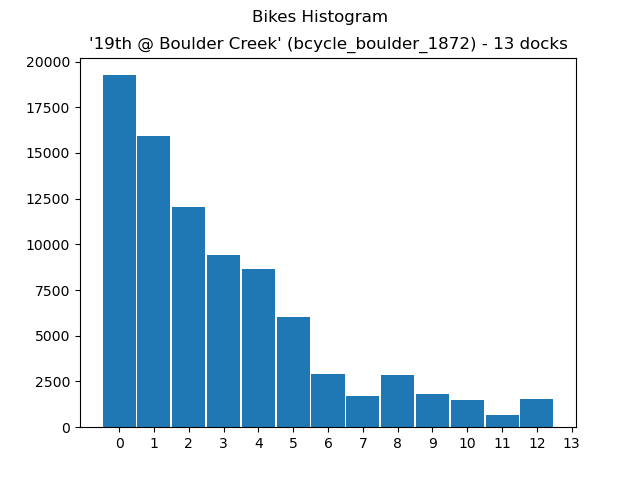

from 84394 updates


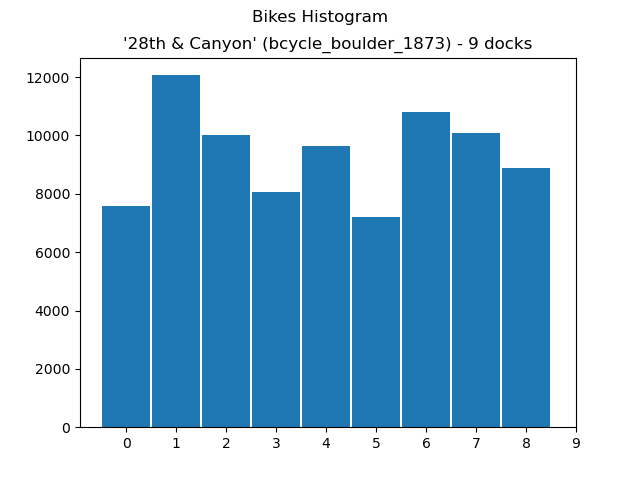

from 84394 updates


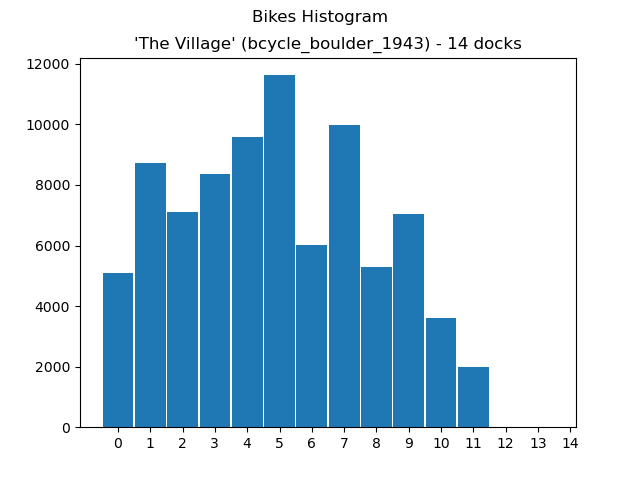

from 84394 updates


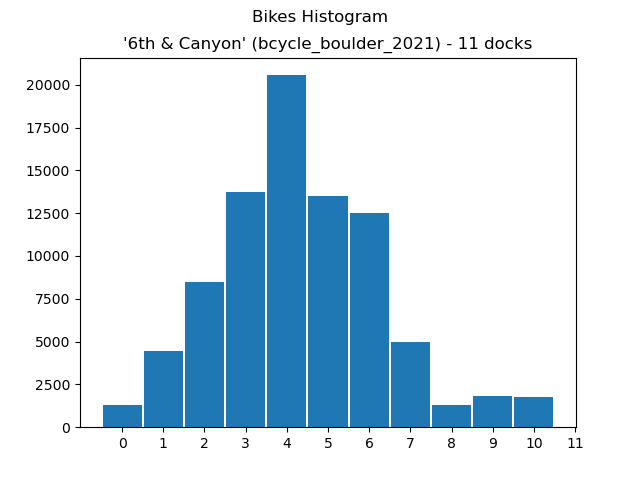

from 84394 updates


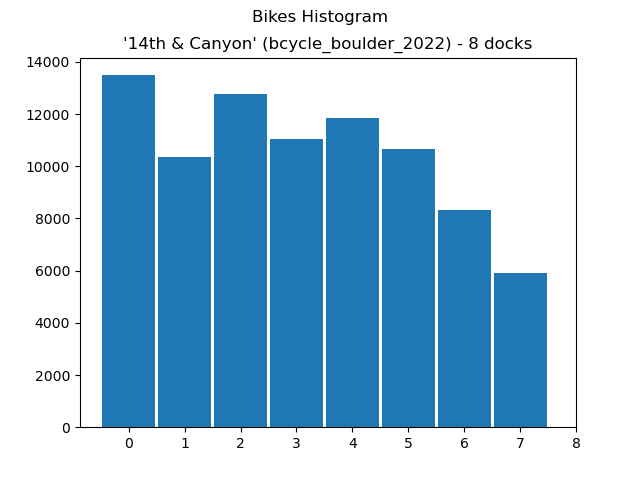

from 84394 updates


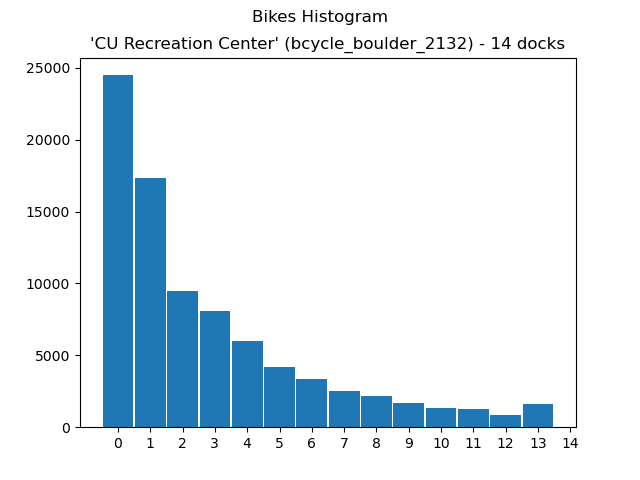

from 84394 updates


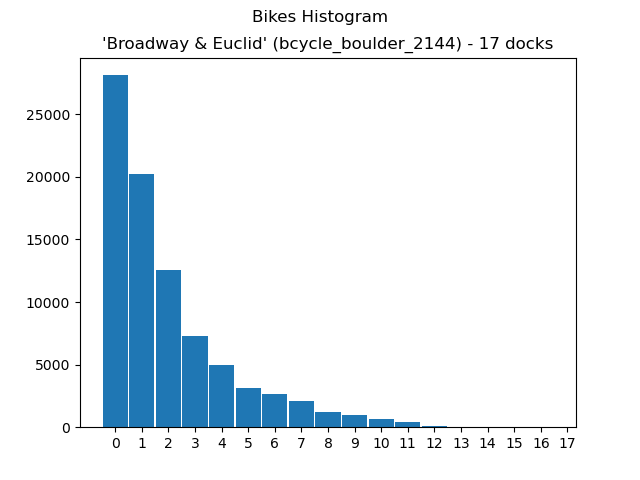

from 84394 updates


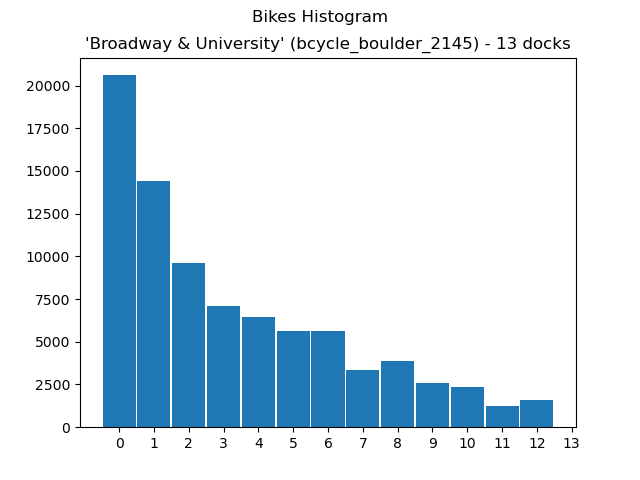

from 84394 updates


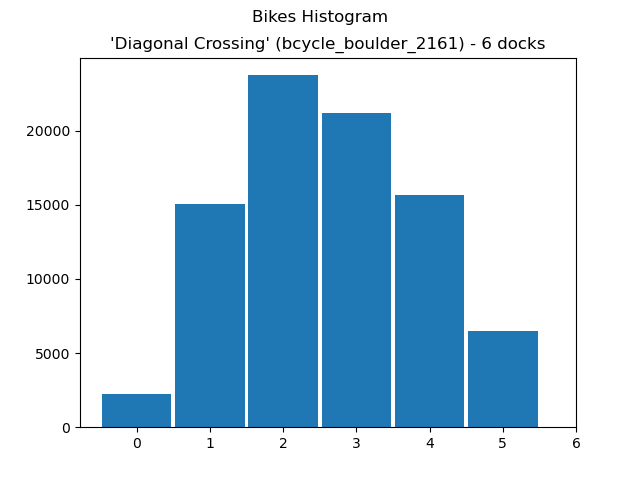

from 84394 updates


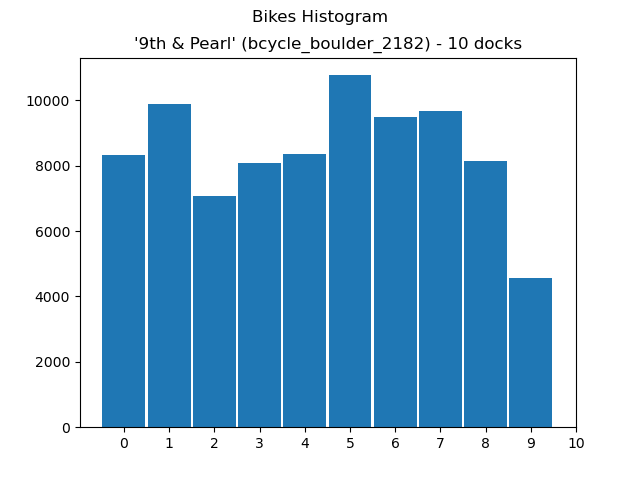

from 84394 updates


<ipython-input-31-948083265fb0>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


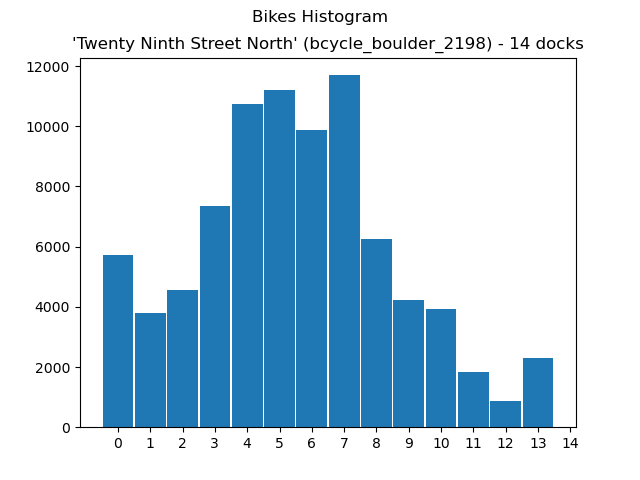

from 84394 updates


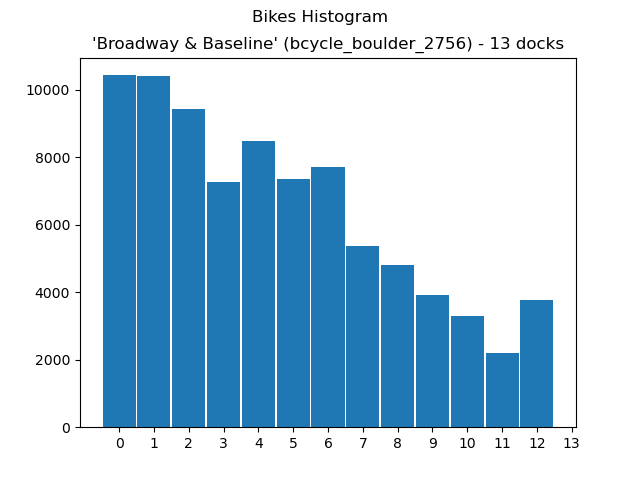

from 84394 updates


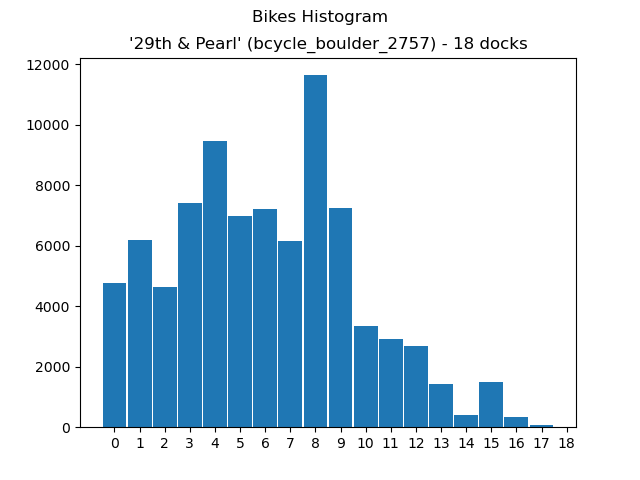

from 84394 updates


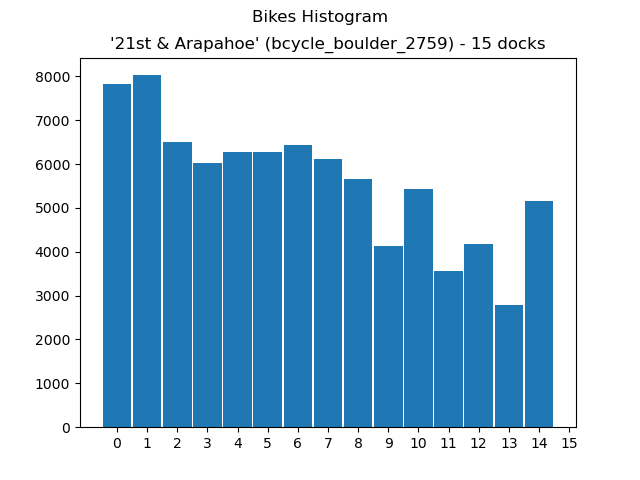

from 84394 updates


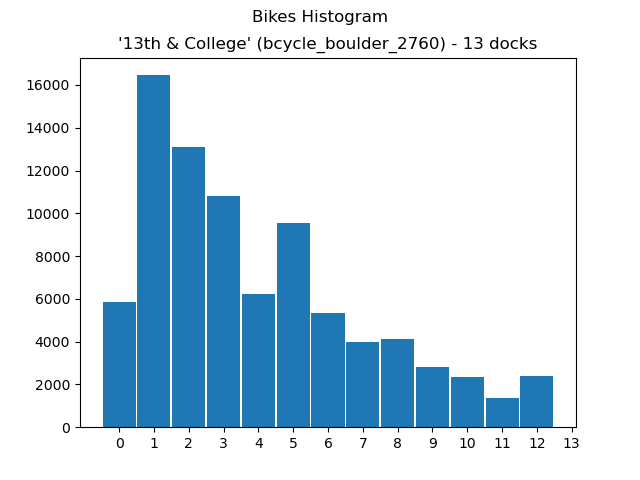

from 84394 updates


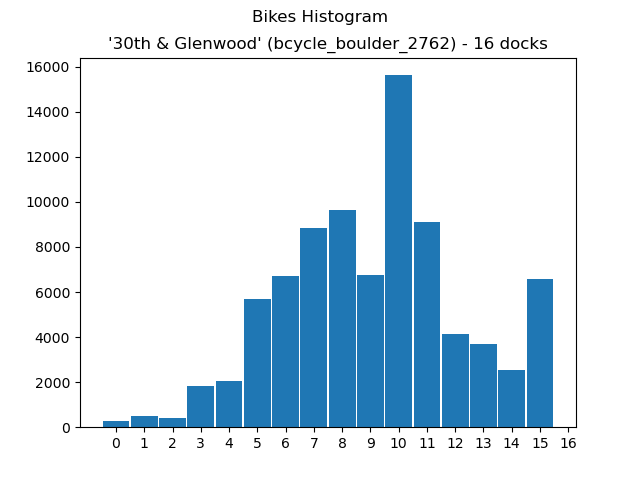

from 84394 updates


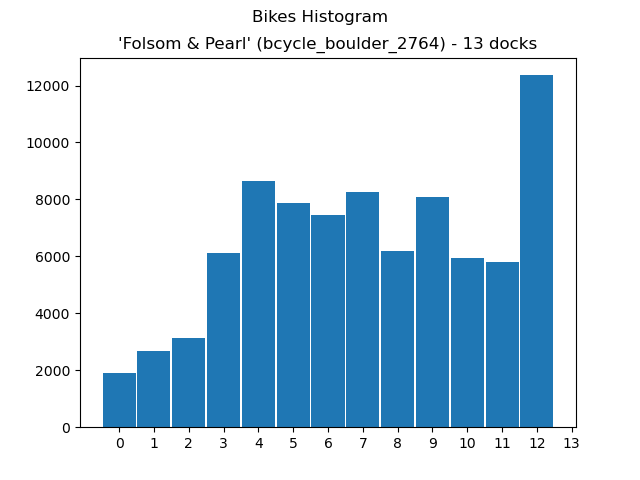

from 84394 updates


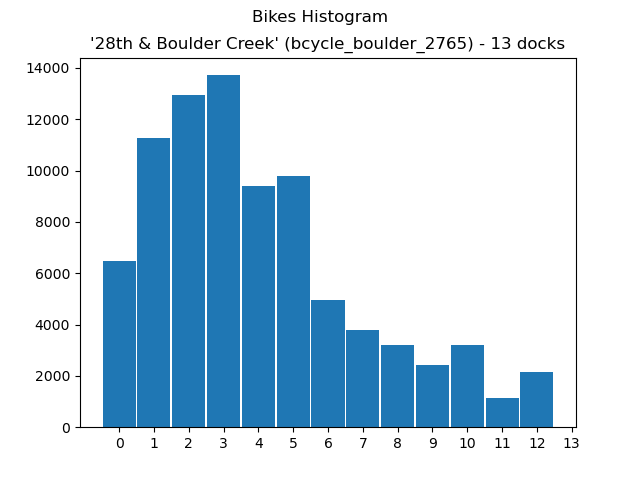

from 84394 updates


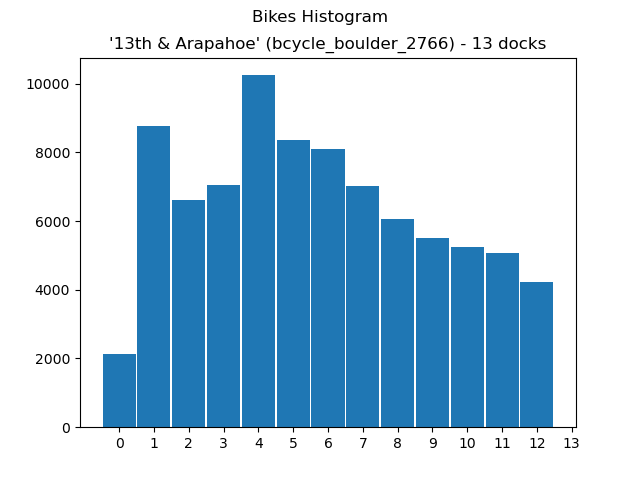

from 84394 updates


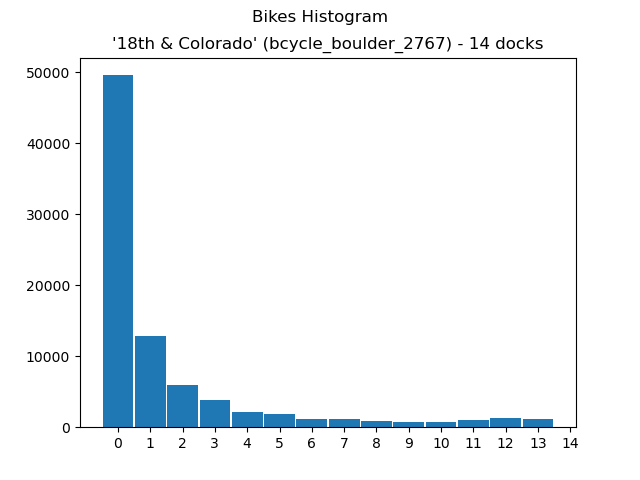

from 84394 updates


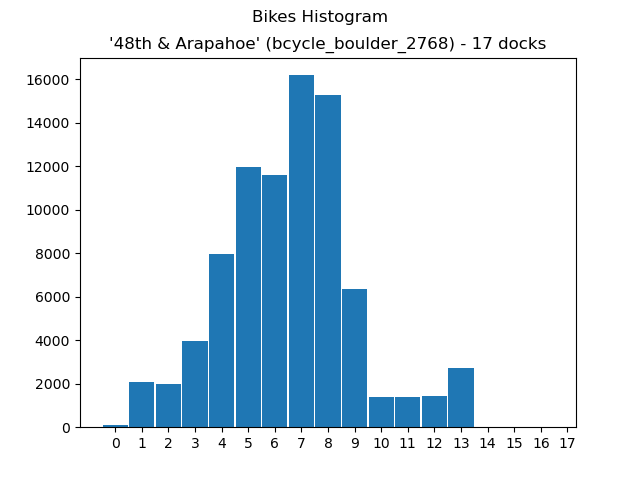

from 84394 updates


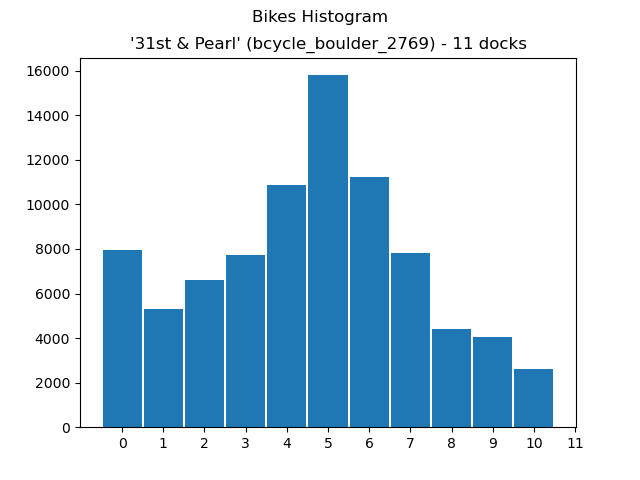

from 84394 updates


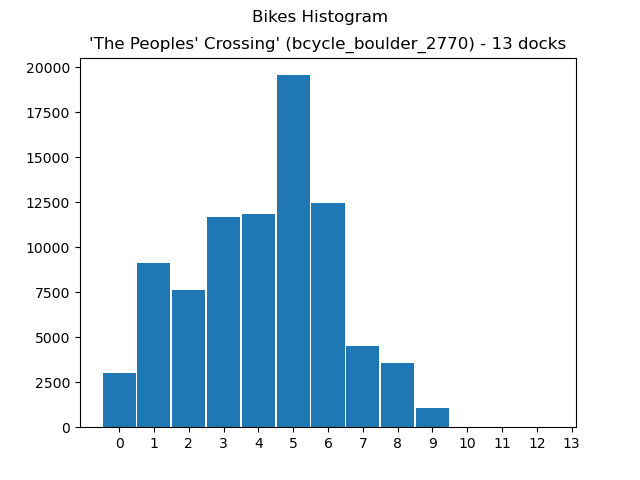

from 84394 updates


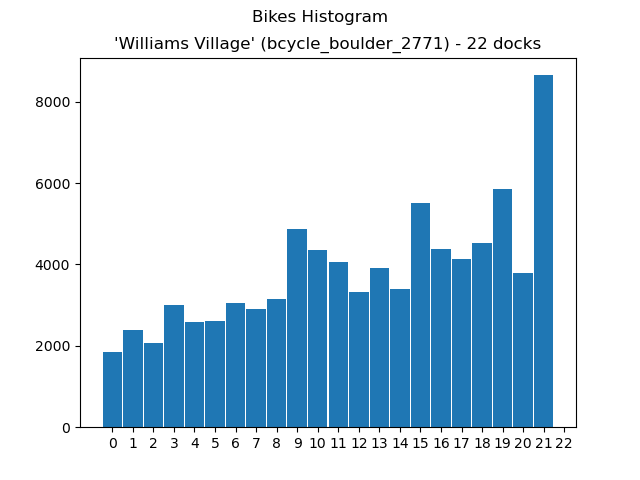

from 84394 updates


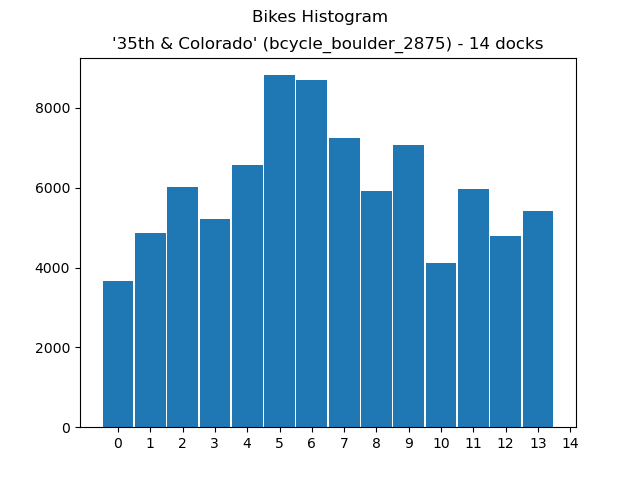

from 84394 updates


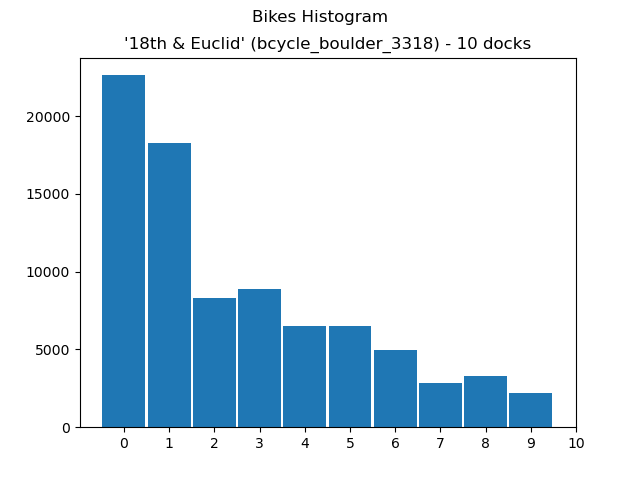

from 84394 updates


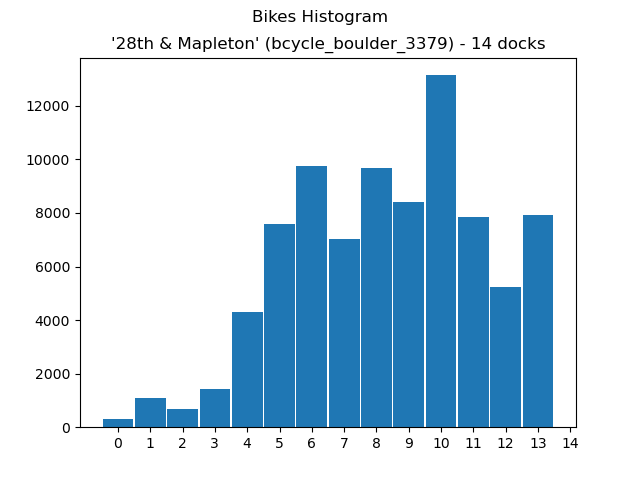

from 84394 updates


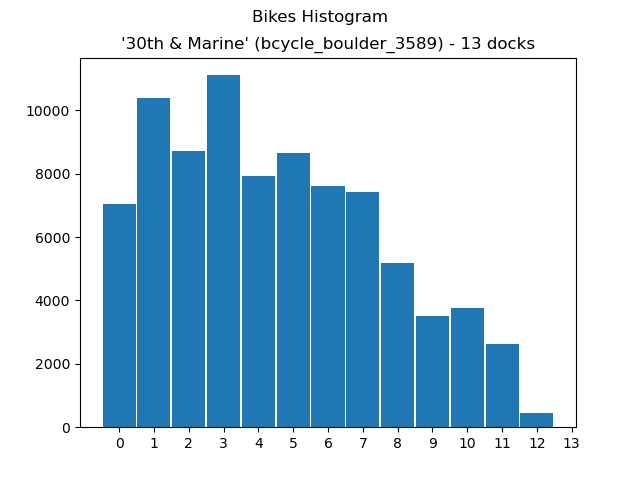

from 84394 updates


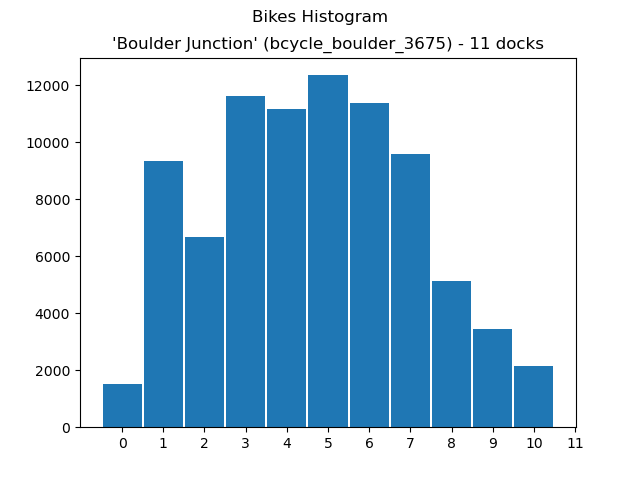

from 84394 updates


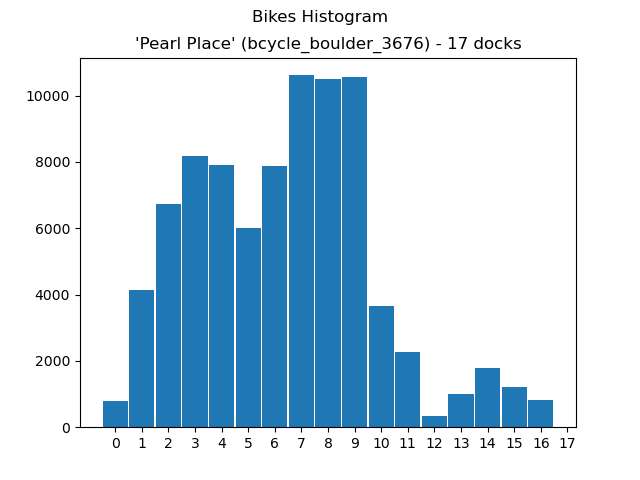

from 84394 updates


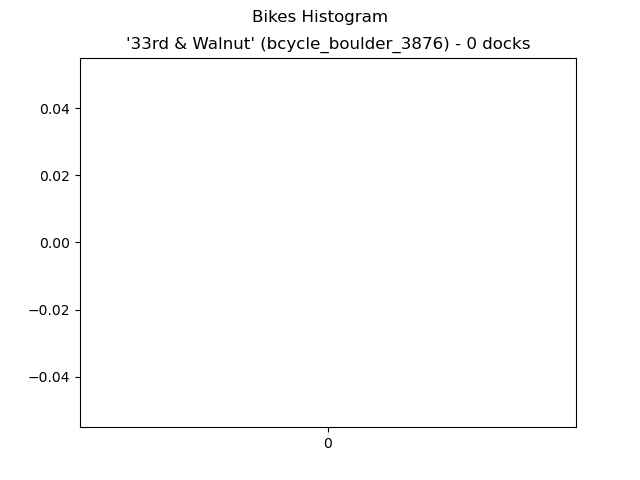

from 10359 updates


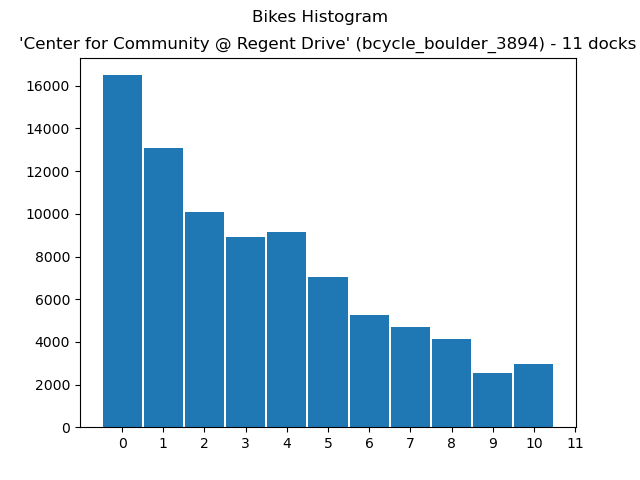

from 84394 updates


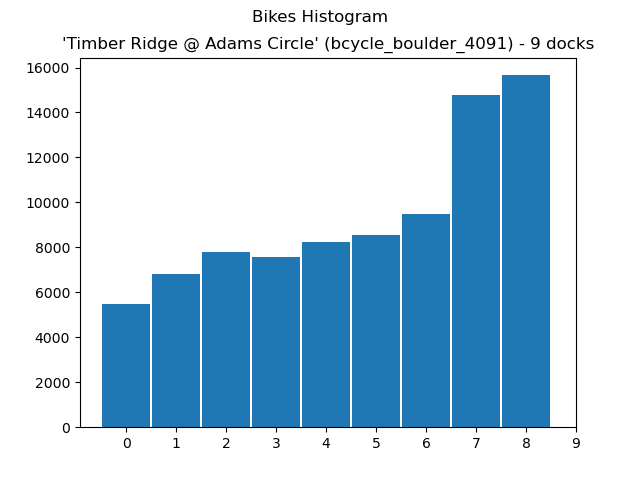

from 84394 updates


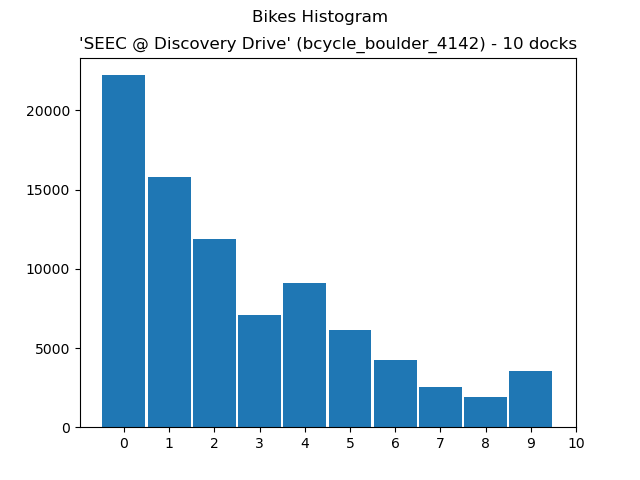

from 84394 updates


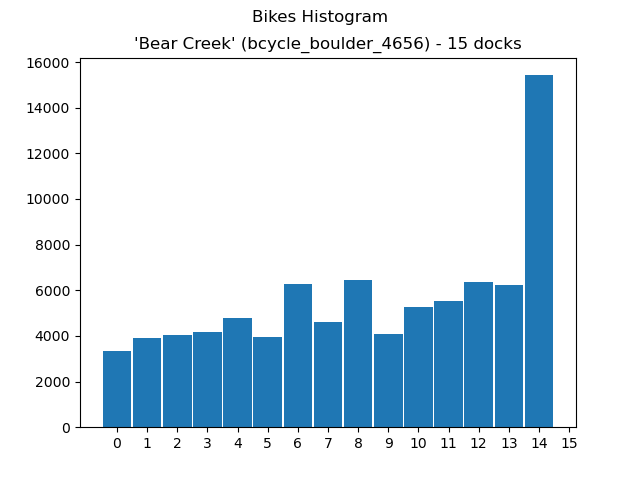

from 84394 updates


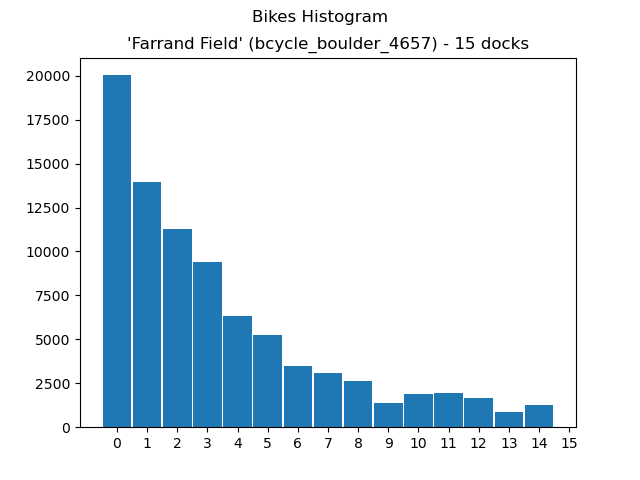

from 84394 updates


In [31]:
#These loops are actually really fast. It's the actual plotting that takes forever.

#for stationID in ('bcycle_boulder_2767'): #18th and Colorado
for stationID in stations:
    bikes = [instant['stations'][stationID]['num_bikes_available'] for instant in data if instant['stations'].get(stationID)]
    
    #plot
    plt.figure()
    plt.suptitle('Bikes Histogram')
    plt.title("\'{}\' ({}) - {} docks".format(stations[stationID]['name'], stationID, stations[stationID]['total_docks']))

    #the range( defines the bin edges, not the number of bins. (0, 1, 2, 3) would give one from 0 to 1, another from 1 to 2, etc.
    h = plt.hist(bikes, bins=range(0, stations[stationID]['total_docks'] + 1, 1), align='left', rwidth=0.95)

    #plt.xlim(0, 1)
    plt.xticks(range(0, stations[stationID]['total_docks'] + 1, 1))

    plt.show()
    print("from {} updates".format(len(bikes)))


### Estimated Station 'Health'
This is an attempt at figuring out what stations have the most problems.<br>

A station is considered to be in an undesirable state if it has too many or too few open docks. (If it has too few, it's possible that a person may not be able to check one out, if it has too many, a person may not be able to check one back in).<br>

This tries to determine if a station is in a bad state by having an absolute minimum amount of bikes and docks (ex. 1) that are acceptable, as well as a relative minimum (ex. 10%). If a station does not meet the larger requirement, it is considered to in an undesirable state. For example, say the absolute min bikes is 1, and the relative min bikes is 0.1, and you're looking at a station with 4 docks. 10% of 4 is 0.4, but that station would have to have 1 full bike in order to be considered good at that time. I know talking about fractional bikes is nonsense, but you know. A station with 20 docks would have to to have 10% bikes, which would be 2, so it would be required to meet that threshold instead of the base 1.

NOTE: I think it might be good to talk to someone from BCycle (Kevin?) about where to set these thresholds. For now, I've tried to set it so that stations with 14 docks need 2.

In [42]:
absDesiredBikes = 1
absDesiredDocks = 1
portionDesiredBikes = 0 #0.125
portionDesiredDocks = 0 #0.125

for instant in data:
    for station in instant['stations']:
        #round() because we only want to require integer bikes. TODO: Is this a good idea?
        requiredBikes = round(max(absDesiredBikes, stations[stationID]['total_docks']*portionDesiredBikes))
        requiredDocks = round(max(absDesiredDocks, stations[stationID]['total_docks']*portionDesiredDocks))
        
        instant['stations'][station]['in_undesirable_state'] = (instant['stations'][station]['num_bikes_available'] < requiredBikes or instant['stations'][station]['num_docks_available'] < requiredDocks)

In [43]:
data[0]['stations']['bcycle_boulder_1855']

{'is_returning': True,
 'is_renting': True,
 'is_installed': True,
 'num_docks_available': 13,
 'num_bikes_available': 0,
 'last_reported': 1644027738,
 'num_bikes_available_types': {'electric': 0, 'smart': 0, 'classic': 0},
 'station_id': 'bcycle_boulder_1855',
 'in_undesirable_state': True}

In [44]:
#what portion of the time each station is in an undesirable state
stationPortionOfTimeUndesirable = {}

for stationID in stations:
    times = 0
    undesirable = 0
    for instant in data:
        if stationID in instant['stations']:
            times += 1
            undesirable += instant['stations'][stationID]['in_undesirable_state']
    
    stationPortionOfTimeUndesirable[stationID] = undesirable/times

In [48]:
for stationID in stationPortionOfTimeUndesirable:
    #TODO: getting the requirements should be a function.
    requiredBikes = round(max(absDesiredBikes, stations[stationID]['total_docks']*portionDesiredBikes))
    requiredDocks = round(max(absDesiredDocks, stations[stationID]['total_docks']*portionDesiredDocks))
    print('{:40s} {:4.1f}% bad'.format(stations[stationID]['name'], stationPortionOfTimeUndesirable[stationID]*100))
    print("Total Docks: {}".format(stations[stationID]['total_docks']))
    print("Required: {} bikes, {} docks\n".format(requiredBikes, requiredDocks))

Folsom & Colorado                        32.6% bad
Total Docks: 15
Required: 1 bikes, 1 docks

15th & Pearl                              5.8% bad
Total Docks: 15
Required: 1 bikes, 1 docks

13th & Spruce                             7.2% bad
Total Docks: 14
Required: 1 bikes, 1 docks

UCAR Center Green                         1.3% bad
Total Docks: 13
Required: 1 bikes, 1 docks

Library @ Arapahoe                       10.7% bad
Total Docks: 11
Required: 1 bikes, 1 docks

26th @ Pearl                              7.1% bad
Total Docks: 11
Required: 1 bikes, 1 docks

Municipal Building                       10.8% bad
Total Docks: 9
Required: 1 bikes, 1 docks

UCAR Mitchell Lane                        1.3% bad
Total Docks: 13
Required: 1 bikes, 1 docks

Broadway & Alpine                         1.5% bad
Total Docks: 13
Required: 1 bikes, 1 docks

19th @ Boulder Creek                     23.9% bad
Total Docks: 13
Required: 1 bikes, 1 docks

28th & Canyon                            13.4% bad


<ipython-input-46-db109573731f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


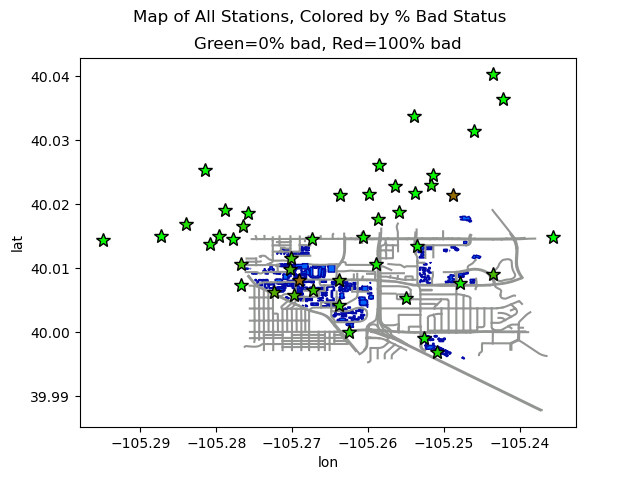

In [46]:
#plot
plt.figure()
plt.suptitle('Map of All Stations, Colored by % Bad Status')
plt.title("Green=0% bad, Red=100% bad")

for building in buildings:
    x = [pair[0] for pair in building['geometry']['coordinates'][0]]
    y = [pair[1] for pair in building['geometry']['coordinates'][0]]

    plt.fill(x, y, facecolor='xkcd:bright blue', edgecolor='xkcd:cobalt blue')

for street in streets:
    x = [pair[0] for pair in street['geometry']['coordinates']]
    y = [pair[1] for pair in street['geometry']['coordinates']]

    plt.plot(x, y, color='xkcd:grey')

#plot each station:
for stationID in stationPortionOfTimeUndesirable:
    r = stationPortionOfTimeUndesirable[stationID]
    g = 1-r
    c = (r, g, 0)
    plt.plot(stations[stationID]['lon'], stations[stationID]['lat'], '*', color=c, markeredgecolor='black', markersize=10, markeredgewidth=1)
    
plt.ylabel('lat')
plt.xlabel('lon')
plt.ticklabel_format(useOffset=False)

plt.show()

### Bad Impact
TODO: I want to have some map of like, which need the most help, which would basically just be the portion bad multiplied by the checkouts per day, but we can only really do that with data from the same time period. So we could use the checkouts and balancing events data, or the GBFS status, and an estimated checkouts number from GBFS, but we couldn't mix and match.